<a href="https://colab.research.google.com/github/brunoklaus/tf-labelprop-BR/blob/master/tf_labelprop_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **This Colab requires GPU usage to work. Please Select Runtime>Change Runtime Type and make sure it is running on a GPU.**

#**Download Github Repo**

---



In [ ]:
import shutil
import os
if os.path.isdir('/content/tf_labelprop'):
  print("Pulling")
  %cd /content/tf_labelprop
  !git pull origin
  %cd /content/tf_labelprop/src/
  import sys
  sys.path.append('/usr/local/lib/python3.7/site-packages')
  sys.path.append('content/tf_labelprop/src')
else:
  !git clone https://github.com/brunoklaus/tf-labelprop-BR tf_labelprop
  !git init -b main
  !git remote add origin https://github.com/brunoklaus/tf-labelprop-BR


Pulling
/content/tf_labelprop
Already up to date.
/content/tf_labelprop/src


# **Download dependencies.** 
#*May take a while.* You only need to run this the first time or if you factory reset runtime. 

This project has quite a few dependencies, including (but not limited to):

*   Conda (needed to install faiss-gpu)

*    Tensorflow 2.x (already included in Google Colab)

*    plotly/chart_studio + orca (to make graph visualizations)

*    LaTeX (to render results), including type1em/type1ec





In [ ]:
#@title Downloading dependencies
!echo $PYTHONPATH
%env PYTHONPATH=
#INSTALL CONDA
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local

#INSTALL FAISS
!conda install faiss-gpu  cudatoolkit=10.0  -c pytorch -y # For CUDA10 
!apt-get -qq install -y libomp-dev

#INSTALL LaTeX
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng


!pip install quadprog==0.1.6
!pip install matplotlib==3.0.3
!pip install scipy==1.3.1
!pip install  docutils==0.14
!pip install pandas==0.23.4
!pip install plotly==3.4.2
!pip install seaborn==0.9.0
!pip install numpy==1.17.1
!pip install MulticoreTSNE==0.1
!pip install progressbar33==2.4
!pip install python_igraph==0.8.2
!pip install reportlab==3.5.50
!pip install scikit_learn==0.23.2
!pip install sslbookdata
!pip install plotly==3.4.2
!pip install chart-studio

import sys
sys.path.append('/content/tf_labelprop/src')
sys.path.append('/usr/local/lib/python3.7/site-packages')



/env/python
env: PYTHONPATH=
--2021-03-13 18:38:04--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   105MB/s    in 0.8s    

2021-03-13 18:38:05 (105 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Traceback (most recent call last):
  File "concurrent/futures/_base.py", line 598, in result_iterator
  File "concurrent/futures/_base.py", line 430, in result
  File "threading.py", line 296, in wait
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last

# **Tutorial 1**:Running an Experiment
# **Tutorial 1, part 0**: Understanding the Experiment class

---
An **Experiment** is a way to encapsulate a set of **configurations** that determine the behaviour of each component in our pipeline. These components are:

*   General Configuration - ``def generalConfig(self):`` - mostly used to set the seed used everywhere else
*   Dataset Fetching / Label Sampling- ``def inputConfig(self):``
*   Affinity Matrix (i.e. graph) generation  - ``def affMatConfig(self):``
*   Noise generating process  - ``def noiseConfig(self):``
*   Filter  - ``def filterConfig(self):`` - Hyperparameters of an (optional) filter that is supposed to correct noisy labels
*   Classifier  - ``def algConfig(self):`` - Hyperparameters of the classifier.

Any **Experiment** must extend `tf_labelprop.experiment.specification.specification_skeleton.EmptySpecification` and specify all of those functions. Each of these function returns a list of dictionaries, representing *all* possible combinations of parameters.  It must also specify the function ``def algConfig(self):``, returning a string with a unique name for this experiment.

To make things easier, we have two tools. The first is what we call an **specification_bit**, which is simply a dictionary mapping keys to a list of possible values. Let us look at two specification bits related to classifiers:

```
ALGORITHM_GFHF_DEFAULT = {
   "algorithm" : [tf_labelprop.gssl.classifiers.GFHF]
}
ALGORITHM_LGC_DEFAULT = {
   "algorithm" : [tf_labelprop.gssl.classifiers.LGCClassifier],
   "alpha" : [0.9,0.99,0.1,0.999]  
}
```

We combine them with our second tool, which is the function **allPermutations** found in `tf_labelprop.experiment.specification.specification_bits import allPermutations`.


A list of all configurations (restricted to the classifier step, that is) is given as a list of "all permutations" of LGC's hyperparameters, concatenated with another list with "all permutations" of GFHF's hyperparameters. In other words, we achieve what we want with
```
from tf_labelprop.experiment.specification.specification_bits import allPermutations as P
def algConfig(self):
      s = spec.ALGORITHM_LGC_DEFAULT
      s1 = spec.ALGORITHM_GFHF_DEFAULT
      return P(s) + P(s1) 
```
---
You can find a few **specification bits** used during my master's degree in `tf_labelprop.experiment.specification.specification_bits`. Here are a few examples
```
import tf_labelprop.input.dataset as ds
INPUT_CHAPELLE = {
        "dataset": [ds.ChapelleDataset],
        "benchmark":["digit1","COIL","USPS","BCI","g241c","g241d"],
        "num_labeled": [10,100],
        "use_chapelle_splits":[True]
        }
```
```
import tf_labelprop.gssl.classifiers as classif 
ALGORITHM_GTAM_DEFAULT = {
   "algorithm" : [classif.GTAMClassifier],
   "weigh_by_degree":[True,False],
   "mu":[0.001,0.0101,0.1111,9,99.0]  
}
```
```
NOISE_UNIFORM_DET_SOME = {
        "corruption_level" : [0,0.1,0.2,0.35],
        "type" : ["NCAR"],
        "deterministic" : [False]
        }
```

```
import tf_labelprop.gssl.filters as filt 
FILTER_LGC_LVO = {
        "filter": [filt.LGC_LVO_Filter],
        "mu": [0.1111,99.0,9.0,0.1111],
         "tuning_iter": [1000],
         "tuning_iter_as_pct":[False],
         "constantProp":[False,True],
         "useZ":[False,True],
        "normalize_rows":[True,False]
        }
```
---



In [ ]:
#@title Choose a dataset from the SSL Book
dataset_name = "COIL" #@param ["COIL", "COIL2", "digit1", "g241c", "g241n", "USPS","BCI", "Text", "SccStr"]



In [ ]:
    from tf_labelprop.logging.logger import _LOG
    import logging
    _LOG.setLevel(logging.ERROR)
    try:
      import tf_labelprop.experiment.specification.specification_bits as spec
      from tf_labelprop.experiment.specification.specification_bits import allPermutations as P
      from tf_labelprop.experiment.specification.exp_chapelle import ExpChapelle
      import tf_labelprop.
      class ExpChapelleColab(ExpChapelle):
          def get_spec_name(self):
              return "Experiment_Chapelle_{}_labels={}_split={}_alg=lgc+gfhf".format(self.ds,self.num_labeled,self.use_chapelle_splits)
          def algConfig(self):
              s = spec.ALGORITHM_LGC_DEFAULT
              s1 = spec.ALGORITHM_GFHF_DEFAULT
              return P(s) + P(s1) 
          def noiseConfig(self):
              s = spec.NOISE_UNIFORM_DET_SOME
              return P(s)
      for ds in [dataset_name]:
          ExpChapelleColab(ds=ds,use_chapelle_splits=True).run_all()
    except:
      _LOG.setLevel(logging.DEBUG)

N/A% (0 of 480) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.7/site-packages', 'content/tf_labelprop/src', '/usr/local/lib/python3.7/site-packages', 'content/tf_labelprop/src', '/usr/local/lib/python3.7/site-packages', 'content/tf_labelprop/src', '/content/tf_labelprop/src', '/usr/local/lib/python3.7/site-packages']
(15, 'knn', '__nan', 'constant', False, <class 'tf_labelprop.input.dataset._toy_ds.ChapelleDataset'>, 'COIL', True)
(15, 'knn', 'mean', 'gaussian', False, <class 'tf_labelprop.input.dataset._toy_ds.ChapelleDataset'>, 'COIL', True)
1
2
/tmp/Experiment_Chapelle_['COIL']_labels=100_split=True_alg=lgc+gfhf/0
/tmp/Experiment_Chapelle_['COIL']_labels=100_split=True_alg=lgc+gfhf/1
[5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 35, 36, 37, 38, 39

  0% (1 of 480) |                        | Elapsed Time: 0:00:01 ETA:   0:13:50

PROGRESS: 0.0020833333333333333


  0% (2 of 480) |                        | Elapsed Time: 0:00:02 ETA:   0:09:49

PROGRESS: 0.004166666666666667


  0% (3 of 480) |                        | Elapsed Time: 0:00:03 ETA:   0:08:26

PROGRESS: 0.00625


  0% (4 of 480) |                        | Elapsed Time: 0:00:03 ETA:   0:05:46

PROGRESS: 0.008333333333333333


  1% (5 of 480) |                        | Elapsed Time: 0:00:04 ETA:   0:05:18

PROGRESS: 0.010416666666666666


  1% (6 of 480) |                        | Elapsed Time: 0:00:05 ETA:   0:05:16

PROGRESS: 0.0125


  1% (7 of 480) |                        | Elapsed Time: 0:00:05 ETA:   0:05:21

PROGRESS: 0.014583333333333334


  1% (8 of 480) |                        | Elapsed Time: 0:00:06 ETA:   0:05:40

PROGRESS: 0.016666666666666666


  1% (9 of 480) |                        | Elapsed Time: 0:00:07 ETA:   0:05:39

PROGRESS: 0.01875


  2% (10 of 480) |                       | Elapsed Time: 0:00:07 ETA:   0:05:17

PROGRESS: 0.020833333333333332


  2% (11 of 480) |                       | Elapsed Time: 0:00:08 ETA:   0:05:18

PROGRESS: 0.022916666666666665


  2% (12 of 480) |                       | Elapsed Time: 0:00:09 ETA:   0:05:13

PROGRESS: 0.025


  2% (13 of 480) |                       | Elapsed Time: 0:00:10 ETA:   0:05:31

PROGRESS: 0.027083333333333334


  2% (14 of 480) |                       | Elapsed Time: 0:00:10 ETA:   0:05:24

PROGRESS: 0.029166666666666667


  3% (15 of 480) |                       | Elapsed Time: 0:00:11 ETA:   0:05:04

PROGRESS: 0.03125


  3% (16 of 480) |                       | Elapsed Time: 0:00:11 ETA:   0:05:03

PROGRESS: 0.03333333333333333


  3% (17 of 480) |                       | Elapsed Time: 0:00:12 ETA:   0:05:04

PROGRESS: 0.035416666666666666


  3% (18 of 480) |                       | Elapsed Time: 0:00:13 ETA:   0:05:26

PROGRESS: 0.0375


  3% (19 of 480) |                       | Elapsed Time: 0:00:14 ETA:   0:05:26

PROGRESS: 0.03958333333333333


  4% (20 of 480) |                       | Elapsed Time: 0:00:14 ETA:   0:05:06

PROGRESS: 0.041666666666666664


  4% (21 of 480) |#                      | Elapsed Time: 0:00:15 ETA:   0:05:04

PROGRESS: 0.04375


  4% (22 of 480) |#                      | Elapsed Time: 0:00:16 ETA:   0:05:02

PROGRESS: 0.04583333333333333


  4% (23 of 480) |#                      | Elapsed Time: 0:00:16 ETA:   0:05:19

PROGRESS: 0.04791666666666667


  5% (24 of 480) |#                      | Elapsed Time: 0:00:17 ETA:   0:05:17

PROGRESS: 0.05


  5% (25 of 480) |#                      | Elapsed Time: 0:00:17 ETA:   0:04:58

PROGRESS: 0.052083333333333336


  5% (26 of 480) |#                      | Elapsed Time: 0:00:18 ETA:   0:05:03

PROGRESS: 0.05416666666666667


  5% (27 of 480) |#                      | Elapsed Time: 0:00:19 ETA:   0:05:01

PROGRESS: 0.05625


  5% (28 of 480) |#                      | Elapsed Time: 0:00:20 ETA:   0:05:22

PROGRESS: 0.058333333333333334


  6% (29 of 480) |#                      | Elapsed Time: 0:00:20 ETA:   0:05:17

PROGRESS: 0.06041666666666667


  6% (30 of 480) |#                      | Elapsed Time: 0:00:21 ETA:   0:04:56

PROGRESS: 0.0625


  6% (31 of 480) |#                      | Elapsed Time: 0:00:22 ETA:   0:04:58

PROGRESS: 0.06458333333333334


  6% (32 of 480) |#                      | Elapsed Time: 0:00:22 ETA:   0:04:56

PROGRESS: 0.06666666666666667


  6% (33 of 480) |#                      | Elapsed Time: 0:00:23 ETA:   0:05:12

PROGRESS: 0.06875


  7% (34 of 480) |#                      | Elapsed Time: 0:00:24 ETA:   0:05:10

PROGRESS: 0.07083333333333333


  7% (35 of 480) |#                      | Elapsed Time: 0:00:24 ETA:   0:04:53

PROGRESS: 0.07291666666666667


  7% (36 of 480) |#                      | Elapsed Time: 0:00:25 ETA:   0:04:53

PROGRESS: 0.075


  7% (37 of 480) |#                      | Elapsed Time: 0:00:26 ETA:   0:04:53

PROGRESS: 0.07708333333333334


  7% (38 of 480) |#                      | Elapsed Time: 0:00:26 ETA:   0:05:10

PROGRESS: 0.07916666666666666


  8% (39 of 480) |#                      | Elapsed Time: 0:00:27 ETA:   0:05:10

PROGRESS: 0.08125


  8% (40 of 480) |#                      | Elapsed Time: 0:00:28 ETA:   0:04:51

PROGRESS: 0.08333333333333333


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

  8% (41 of 480) |#                      | Elapsed Time: 0:00:28 ETA:   0:04:50

PROGRESS: 0.08541666666666667


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

  8% (42 of 480) |##                     | Elapsed Time: 0:00:29 ETA:   0:04:53

PROGRESS: 0.0875


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

  8% (43 of 480) |##                     | Elapsed Time: 0:00:30 ETA:   0:05:14

PROGRESS: 0.08958333333333333


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

  9% (44 of 480) |##                     | Elapsed Time: 0:00:30 ETA:   0:05:13

PROGRESS: 0.09166666666666666


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

  9% (45 of 480) |##                     | Elapsed Time: 0:00:31 ETA:   0:04:52

PROGRESS: 0.09375


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

  9% (46 of 480) |##                     | Elapsed Time: 0:00:32 ETA:   0:04:48

PROGRESS: 0.09583333333333334


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

  9% (47 of 480) |##                     | Elapsed Time: 0:00:32 ETA:   0:04:48

PROGRESS: 0.09791666666666667


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 10% (48 of 480) |##                     | Elapsed Time: 0:00:33 ETA:   0:05:07

PROGRESS: 0.1


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 10% (49 of 480) |##                     | Elapsed Time: 0:00:34 ETA:   0:05:08

PROGRESS: 0.10208333333333333


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 10% (50 of 480) |##                     | Elapsed Time: 0:00:34 ETA:   0:04:48

PROGRESS: 0.10416666666666667


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 10% (51 of 480) |##                     | Elapsed Time: 0:00:35 ETA:   0:04:48

PROGRESS: 0.10625


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 10% (52 of 480) |##                     | Elapsed Time: 0:00:36 ETA:   0:04:47

PROGRESS: 0.10833333333333334


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 11% (53 of 480) |##                     | Elapsed Time: 0:00:36 ETA:   0:05:07

PROGRESS: 0.11041666666666666


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 11% (54 of 480) |##                     | Elapsed Time: 0:00:37 ETA:   0:05:04

PROGRESS: 0.1125


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 11% (55 of 480) |##                     | Elapsed Time: 0:00:38 ETA:   0:04:46

PROGRESS: 0.11458333333333333


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 11% (56 of 480) |##                     | Elapsed Time: 0:00:38 ETA:   0:04:45

PROGRESS: 0.11666666666666667


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 11% (57 of 480) |##                     | Elapsed Time: 0:00:39 ETA:   0:04:42

PROGRESS: 0.11875


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 12% (58 of 480) |##                     | Elapsed Time: 0:00:40 ETA:   0:05:06

PROGRESS: 0.12083333333333333


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 12% (59 of 480) |##                     | Elapsed Time: 0:00:41 ETA:   0:05:07

PROGRESS: 0.12291666666666666


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 12% (60 of 480) |##                     | Elapsed Time: 0:00:41 ETA:   0:04:47

PROGRESS: 0.125


 12% (61 of 480) |##                     | Elapsed Time: 0:00:42 ETA:   0:04:44

PROGRESS: 0.12708333333333333


 12% (62 of 480) |##                     | Elapsed Time: 0:00:43 ETA:   0:04:43

PROGRESS: 0.12916666666666668


 13% (63 of 480) |###                    | Elapsed Time: 0:00:43 ETA:   0:05:01

PROGRESS: 0.13125


 13% (64 of 480) |###                    | Elapsed Time: 0:00:44 ETA:   0:05:00

PROGRESS: 0.13333333333333333


 13% (65 of 480) |###                    | Elapsed Time: 0:00:45 ETA:   0:04:38

PROGRESS: 0.13541666666666666


 13% (66 of 480) |###                    | Elapsed Time: 0:00:45 ETA:   0:04:38

PROGRESS: 0.1375


 13% (67 of 480) |###                    | Elapsed Time: 0:00:46 ETA:   0:04:34

PROGRESS: 0.13958333333333334


 14% (68 of 480) |###                    | Elapsed Time: 0:00:47 ETA:   0:04:53

PROGRESS: 0.14166666666666666


 14% (69 of 480) |###                    | Elapsed Time: 0:00:47 ETA:   0:04:51

PROGRESS: 0.14375


 14% (70 of 480) |###                    | Elapsed Time: 0:00:48 ETA:   0:04:34

PROGRESS: 0.14583333333333334


 14% (71 of 480) |###                    | Elapsed Time: 0:00:49 ETA:   0:04:34

PROGRESS: 0.14791666666666667


 15% (72 of 480) |###                    | Elapsed Time: 0:00:49 ETA:   0:04:32

PROGRESS: 0.15


 15% (73 of 480) |###                    | Elapsed Time: 0:00:50 ETA:   0:04:56

PROGRESS: 0.15208333333333332


 15% (74 of 480) |###                    | Elapsed Time: 0:00:51 ETA:   0:04:56

PROGRESS: 0.15416666666666667


 15% (75 of 480) |###                    | Elapsed Time: 0:00:51 ETA:   0:04:35

PROGRESS: 0.15625


 15% (76 of 480) |###                    | Elapsed Time: 0:00:52 ETA:   0:04:31

PROGRESS: 0.15833333333333333


 16% (77 of 480) |###                    | Elapsed Time: 0:00:53 ETA:   0:04:26

PROGRESS: 0.16041666666666668


 16% (78 of 480) |###                    | Elapsed Time: 0:00:54 ETA:   0:04:45

PROGRESS: 0.1625


 16% (79 of 480) |###                    | Elapsed Time: 0:00:54 ETA:   0:04:44

PROGRESS: 0.16458333333333333


 16% (80 of 480) |###                    | Elapsed Time: 0:00:55 ETA:   0:04:26

PROGRESS: 0.16666666666666666


 16% (81 of 480) |###                    | Elapsed Time: 0:00:55 ETA:   0:04:27

PROGRESS: 0.16875


 17% (82 of 480) |###                    | Elapsed Time: 0:00:56 ETA:   0:04:27

PROGRESS: 0.17083333333333334


 17% (83 of 480) |###                    | Elapsed Time: 0:00:57 ETA:   0:04:48

PROGRESS: 0.17291666666666666


 17% (84 of 480) |####                   | Elapsed Time: 0:00:58 ETA:   0:04:44

PROGRESS: 0.175


 17% (85 of 480) |####                   | Elapsed Time: 0:00:58 ETA:   0:04:26

PROGRESS: 0.17708333333333334


 17% (86 of 480) |####                   | Elapsed Time: 0:00:59 ETA:   0:04:22

PROGRESS: 0.17916666666666667


 18% (87 of 480) |####                   | Elapsed Time: 0:01:00 ETA:   0:04:18

PROGRESS: 0.18125


 18% (88 of 480) |####                   | Elapsed Time: 0:01:00 ETA:   0:04:39

PROGRESS: 0.18333333333333332


 18% (89 of 480) |####                   | Elapsed Time: 0:01:01 ETA:   0:04:39

PROGRESS: 0.18541666666666667


 18% (90 of 480) |####                   | Elapsed Time: 0:01:02 ETA:   0:04:21

PROGRESS: 0.1875


 18% (91 of 480) |####                   | Elapsed Time: 0:01:02 ETA:   0:04:22

PROGRESS: 0.18958333333333333


 19% (92 of 480) |####                   | Elapsed Time: 0:01:03 ETA:   0:04:21

PROGRESS: 0.19166666666666668


 19% (93 of 480) |####                   | Elapsed Time: 0:01:04 ETA:   0:04:36

PROGRESS: 0.19375


 19% (94 of 480) |####                   | Elapsed Time: 0:01:04 ETA:   0:04:33

PROGRESS: 0.19583333333333333


 19% (95 of 480) |####                   | Elapsed Time: 0:01:05 ETA:   0:04:17

PROGRESS: 0.19791666666666666


 20% (96 of 480) |####                   | Elapsed Time: 0:01:06 ETA:   0:04:15

PROGRESS: 0.2


 20% (97 of 480) |####                   | Elapsed Time: 0:01:06 ETA:   0:04:15

PROGRESS: 0.20208333333333334


 20% (98 of 480) |####                   | Elapsed Time: 0:01:07 ETA:   0:04:31

PROGRESS: 0.20416666666666666


 20% (99 of 480) |####                   | Elapsed Time: 0:01:08 ETA:   0:04:31

PROGRESS: 0.20625


 20% (100 of 480) |####                  | Elapsed Time: 0:01:08 ETA:   0:04:16

PROGRESS: 0.20833333333333334


 21% (101 of 480) |####                  | Elapsed Time: 0:01:09 ETA:   0:04:15

PROGRESS: 0.21041666666666667


 21% (102 of 480) |####                  | Elapsed Time: 0:01:10 ETA:   0:04:12

PROGRESS: 0.2125


 21% (103 of 480) |####                  | Elapsed Time: 0:01:11 ETA:   0:04:37

PROGRESS: 0.21458333333333332


 21% (104 of 480) |####                  | Elapsed Time: 0:01:11 ETA:   0:04:36

PROGRESS: 0.21666666666666667


 21% (105 of 480) |####                  | Elapsed Time: 0:01:12 ETA:   0:04:10

PROGRESS: 0.21875


 22% (106 of 480) |####                  | Elapsed Time: 0:01:13 ETA:   0:04:15

PROGRESS: 0.22083333333333333


 22% (107 of 480) |####                  | Elapsed Time: 0:01:13 ETA:   0:04:10

PROGRESS: 0.22291666666666668


 22% (108 of 480) |####                  | Elapsed Time: 0:01:14 ETA:   0:04:26

PROGRESS: 0.225


 22% (109 of 480) |####                  | Elapsed Time: 0:01:15 ETA:   0:04:22

PROGRESS: 0.22708333333333333


 22% (110 of 480) |#####                 | Elapsed Time: 0:01:15 ETA:   0:04:05

PROGRESS: 0.22916666666666666


 23% (111 of 480) |#####                 | Elapsed Time: 0:01:16 ETA:   0:04:04

PROGRESS: 0.23125


 23% (112 of 480) |#####                 | Elapsed Time: 0:01:17 ETA:   0:04:04

PROGRESS: 0.23333333333333334


 23% (113 of 480) |#####                 | Elapsed Time: 0:01:17 ETA:   0:04:19

PROGRESS: 0.23541666666666666


 23% (114 of 480) |#####                 | Elapsed Time: 0:01:18 ETA:   0:04:17

PROGRESS: 0.2375


 23% (115 of 480) |#####                 | Elapsed Time: 0:01:19 ETA:   0:04:02

PROGRESS: 0.23958333333333334


 24% (116 of 480) |#####                 | Elapsed Time: 0:01:19 ETA:   0:04:00

PROGRESS: 0.24166666666666667


 24% (117 of 480) |#####                 | Elapsed Time: 0:01:20 ETA:   0:04:01

PROGRESS: 0.24375


 24% (118 of 480) |#####                 | Elapsed Time: 0:01:21 ETA:   0:04:18

PROGRESS: 0.24583333333333332


 24% (119 of 480) |#####                 | Elapsed Time: 0:01:21 ETA:   0:04:18

PROGRESS: 0.24791666666666667


 25% (120 of 480) |#####                 | Elapsed Time: 0:01:22 ETA:   0:04:01

PROGRESS: 0.25


 25% (121 of 480) |#####                 | Elapsed Time: 0:01:23 ETA:   0:04:00

PROGRESS: 0.2520833333333333


 25% (122 of 480) |#####                 | Elapsed Time: 0:01:23 ETA:   0:03:56

PROGRESS: 0.25416666666666665


 25% (123 of 480) |#####                 | Elapsed Time: 0:01:24 ETA:   0:04:11

PROGRESS: 0.25625


 25% (124 of 480) |#####                 | Elapsed Time: 0:01:25 ETA:   0:04:13

PROGRESS: 0.25833333333333336


 26% (125 of 480) |#####                 | Elapsed Time: 0:01:25 ETA:   0:03:57

PROGRESS: 0.2604166666666667


 26% (126 of 480) |#####                 | Elapsed Time: 0:01:26 ETA:   0:03:57

PROGRESS: 0.2625


 26% (127 of 480) |#####                 | Elapsed Time: 0:01:27 ETA:   0:03:58

PROGRESS: 0.26458333333333334


 26% (128 of 480) |#####                 | Elapsed Time: 0:01:27 ETA:   0:04:11

PROGRESS: 0.26666666666666666


 26% (129 of 480) |#####                 | Elapsed Time: 0:01:28 ETA:   0:04:12

PROGRESS: 0.26875


 27% (130 of 480) |#####                 | Elapsed Time: 0:01:29 ETA:   0:03:57

PROGRESS: 0.2708333333333333


 27% (131 of 480) |######                | Elapsed Time: 0:01:29 ETA:   0:03:53

PROGRESS: 0.27291666666666664


 27% (132 of 480) |######                | Elapsed Time: 0:01:30 ETA:   0:03:52

PROGRESS: 0.275


 27% (133 of 480) |######                | Elapsed Time: 0:01:31 ETA:   0:04:02

PROGRESS: 0.27708333333333335


 27% (134 of 480) |######                | Elapsed Time: 0:01:32 ETA:   0:04:04

PROGRESS: 0.2791666666666667


 28% (135 of 480) |######                | Elapsed Time: 0:01:32 ETA:   0:03:50

PROGRESS: 0.28125


 28% (136 of 480) |######                | Elapsed Time: 0:01:33 ETA:   0:03:51

PROGRESS: 0.2833333333333333


 28% (137 of 480) |######                | Elapsed Time: 0:01:34 ETA:   0:03:51

PROGRESS: 0.28541666666666665


 28% (138 of 480) |######                | Elapsed Time: 0:01:34 ETA:   0:04:03

PROGRESS: 0.2875


 28% (139 of 480) |######                | Elapsed Time: 0:01:35 ETA:   0:04:02

PROGRESS: 0.28958333333333336


 29% (140 of 480) |######                | Elapsed Time: 0:01:35 ETA:   0:03:45

PROGRESS: 0.2916666666666667


 29% (141 of 480) |######                | Elapsed Time: 0:01:36 ETA:   0:03:46

PROGRESS: 0.29375


 29% (142 of 480) |######                | Elapsed Time: 0:01:37 ETA:   0:03:44

PROGRESS: 0.29583333333333334


 29% (143 of 480) |######                | Elapsed Time: 0:01:38 ETA:   0:03:58

PROGRESS: 0.29791666666666666


 30% (144 of 480) |######                | Elapsed Time: 0:01:38 ETA:   0:03:57

PROGRESS: 0.3


 30% (145 of 480) |######                | Elapsed Time: 0:01:39 ETA:   0:03:43

PROGRESS: 0.3020833333333333


 30% (146 of 480) |######                | Elapsed Time: 0:01:40 ETA:   0:03:42

PROGRESS: 0.30416666666666664


 30% (147 of 480) |######                | Elapsed Time: 0:01:40 ETA:   0:03:42

PROGRESS: 0.30625


 30% (148 of 480) |######                | Elapsed Time: 0:01:41 ETA:   0:03:56

PROGRESS: 0.30833333333333335


 31% (149 of 480) |######                | Elapsed Time: 0:01:42 ETA:   0:03:58

PROGRESS: 0.3104166666666667


 31% (150 of 480) |######                | Elapsed Time: 0:01:42 ETA:   0:03:42

PROGRESS: 0.3125


 31% (151 of 480) |######                | Elapsed Time: 0:01:43 ETA:   0:03:42

PROGRESS: 0.3145833333333333


 31% (152 of 480) |######                | Elapsed Time: 0:01:44 ETA:   0:03:42

PROGRESS: 0.31666666666666665


 31% (153 of 480) |#######               | Elapsed Time: 0:01:44 ETA:   0:03:54

PROGRESS: 0.31875


 32% (154 of 480) |#######               | Elapsed Time: 0:01:45 ETA:   0:03:53

PROGRESS: 0.32083333333333336


 32% (155 of 480) |#######               | Elapsed Time: 0:01:46 ETA:   0:03:38

PROGRESS: 0.3229166666666667


 32% (156 of 480) |#######               | Elapsed Time: 0:01:46 ETA:   0:03:36

PROGRESS: 0.325


 32% (157 of 480) |#######               | Elapsed Time: 0:01:47 ETA:   0:03:36

PROGRESS: 0.32708333333333334


 32% (158 of 480) |#######               | Elapsed Time: 0:01:48 ETA:   0:03:48

PROGRESS: 0.32916666666666666


 33% (159 of 480) |#######               | Elapsed Time: 0:01:49 ETA:   0:03:47

PROGRESS: 0.33125


 33% (160 of 480) |#######               | Elapsed Time: 0:01:49 ETA:   0:03:33

PROGRESS: 0.3333333333333333


 33% (161 of 480) |#######               | Elapsed Time: 0:01:50 ETA:   0:03:32

PROGRESS: 0.33541666666666664


 33% (162 of 480) |#######               | Elapsed Time: 0:01:51 ETA:   0:03:31

PROGRESS: 0.3375


 33% (163 of 480) |#######               | Elapsed Time: 0:01:51 ETA:   0:03:42

PROGRESS: 0.33958333333333335


 34% (164 of 480) |#######               | Elapsed Time: 0:01:52 ETA:   0:03:42

PROGRESS: 0.3416666666666667


 34% (165 of 480) |#######               | Elapsed Time: 0:01:52 ETA:   0:03:30

PROGRESS: 0.34375


 34% (166 of 480) |#######               | Elapsed Time: 0:01:53 ETA:   0:03:29

PROGRESS: 0.3458333333333333


 34% (167 of 480) |#######               | Elapsed Time: 0:01:54 ETA:   0:03:29

PROGRESS: 0.34791666666666665


 35% (168 of 480) |#######               | Elapsed Time: 0:01:55 ETA:   0:03:41

PROGRESS: 0.35


 35% (169 of 480) |#######               | Elapsed Time: 0:01:55 ETA:   0:03:40

PROGRESS: 0.35208333333333336


 35% (170 of 480) |#######               | Elapsed Time: 0:01:56 ETA:   0:03:26

PROGRESS: 0.3541666666666667


 35% (171 of 480) |#######               | Elapsed Time: 0:01:57 ETA:   0:03:25

PROGRESS: 0.35625


 35% (172 of 480) |#######               | Elapsed Time: 0:01:57 ETA:   0:03:23

PROGRESS: 0.35833333333333334


 36% (173 of 480) |#######               | Elapsed Time: 0:01:58 ETA:   0:03:36

PROGRESS: 0.36041666666666666


 36% (174 of 480) |#######               | Elapsed Time: 0:01:59 ETA:   0:03:35

PROGRESS: 0.3625


 36% (175 of 480) |########              | Elapsed Time: 0:01:59 ETA:   0:03:21

PROGRESS: 0.3645833333333333


 36% (176 of 480) |########              | Elapsed Time: 0:02:00 ETA:   0:03:23

PROGRESS: 0.36666666666666664


 36% (177 of 480) |########              | Elapsed Time: 0:02:01 ETA:   0:03:23

PROGRESS: 0.36875


 37% (178 of 480) |########              | Elapsed Time: 0:02:01 ETA:   0:03:35

PROGRESS: 0.37083333333333335


 37% (179 of 480) |########              | Elapsed Time: 0:02:02 ETA:   0:03:34

PROGRESS: 0.3729166666666667


 37% (180 of 480) |########              | Elapsed Time: 0:02:03 ETA:   0:03:22

PROGRESS: 0.375


 37% (181 of 480) |########              | Elapsed Time: 0:02:03 ETA:   0:03:19

PROGRESS: 0.3770833333333333


 37% (182 of 480) |########              | Elapsed Time: 0:02:04 ETA:   0:03:19

PROGRESS: 0.37916666666666665


 38% (183 of 480) |########              | Elapsed Time: 0:02:05 ETA:   0:03:35

PROGRESS: 0.38125


 38% (184 of 480) |########              | Elapsed Time: 0:02:06 ETA:   0:03:33

PROGRESS: 0.38333333333333336


 38% (185 of 480) |########              | Elapsed Time: 0:02:06 ETA:   0:03:20

PROGRESS: 0.3854166666666667


 38% (186 of 480) |########              | Elapsed Time: 0:02:07 ETA:   0:03:19

PROGRESS: 0.3875


 38% (187 of 480) |########              | Elapsed Time: 0:02:08 ETA:   0:03:17

PROGRESS: 0.38958333333333334


 39% (188 of 480) |########              | Elapsed Time: 0:02:08 ETA:   0:03:32

PROGRESS: 0.39166666666666666


 39% (189 of 480) |########              | Elapsed Time: 0:02:09 ETA:   0:03:32

PROGRESS: 0.39375


 39% (190 of 480) |########              | Elapsed Time: 0:02:10 ETA:   0:03:14

PROGRESS: 0.3958333333333333


 39% (191 of 480) |########              | Elapsed Time: 0:02:10 ETA:   0:03:16

PROGRESS: 0.39791666666666664


 40% (192 of 480) |########              | Elapsed Time: 0:02:11 ETA:   0:03:14

PROGRESS: 0.4


 40% (193 of 480) |########              | Elapsed Time: 0:02:12 ETA:   0:03:27

PROGRESS: 0.40208333333333335


 40% (194 of 480) |########              | Elapsed Time: 0:02:12 ETA:   0:03:27

PROGRESS: 0.4041666666666667


 40% (195 of 480) |########              | Elapsed Time: 0:02:13 ETA:   0:03:10

PROGRESS: 0.40625


 40% (196 of 480) |########              | Elapsed Time: 0:02:14 ETA:   0:03:11

PROGRESS: 0.4083333333333333


 41% (197 of 480) |#########             | Elapsed Time: 0:02:14 ETA:   0:03:12

PROGRESS: 0.41041666666666665


 41% (198 of 480) |#########             | Elapsed Time: 0:02:15 ETA:   0:03:24

PROGRESS: 0.4125


 41% (199 of 480) |#########             | Elapsed Time: 0:02:16 ETA:   0:03:23

PROGRESS: 0.41458333333333336


 41% (200 of 480) |#########             | Elapsed Time: 0:02:16 ETA:   0:03:08

PROGRESS: 0.4166666666666667


 41% (201 of 480) |#########             | Elapsed Time: 0:02:17 ETA:   0:03:08

PROGRESS: 0.41875


 42% (202 of 480) |#########             | Elapsed Time: 0:02:18 ETA:   0:03:10

PROGRESS: 0.42083333333333334


 42% (203 of 480) |#########             | Elapsed Time: 0:02:19 ETA:   0:03:21

PROGRESS: 0.42291666666666666


 42% (204 of 480) |#########             | Elapsed Time: 0:02:19 ETA:   0:03:19

PROGRESS: 0.425


 42% (205 of 480) |#########             | Elapsed Time: 0:02:20 ETA:   0:03:03

PROGRESS: 0.4270833333333333


 42% (206 of 480) |#########             | Elapsed Time: 0:02:21 ETA:   0:03:06

PROGRESS: 0.42916666666666664


 43% (207 of 480) |#########             | Elapsed Time: 0:02:21 ETA:   0:03:03

PROGRESS: 0.43125


 43% (208 of 480) |#########             | Elapsed Time: 0:02:22 ETA:   0:03:18

PROGRESS: 0.43333333333333335


 43% (209 of 480) |#########             | Elapsed Time: 0:02:23 ETA:   0:03:18

PROGRESS: 0.4354166666666667


 43% (210 of 480) |#########             | Elapsed Time: 0:02:23 ETA:   0:03:00

PROGRESS: 0.4375


 43% (211 of 480) |#########             | Elapsed Time: 0:02:24 ETA:   0:03:00

PROGRESS: 0.4395833333333333


 44% (212 of 480) |#########             | Elapsed Time: 0:02:25 ETA:   0:02:58

PROGRESS: 0.44166666666666665


 44% (213 of 480) |#########             | Elapsed Time: 0:02:26 ETA:   0:03:13

PROGRESS: 0.44375


 44% (214 of 480) |#########             | Elapsed Time: 0:02:26 ETA:   0:03:11

PROGRESS: 0.44583333333333336


 44% (215 of 480) |#########             | Elapsed Time: 0:02:27 ETA:   0:02:58

PROGRESS: 0.4479166666666667


 45% (216 of 480) |#########             | Elapsed Time: 0:02:28 ETA:   0:02:58

PROGRESS: 0.45


 45% (217 of 480) |#########             | Elapsed Time: 0:02:28 ETA:   0:02:58

PROGRESS: 0.45208333333333334


 45% (218 of 480) |#########             | Elapsed Time: 0:02:29 ETA:   0:03:11

PROGRESS: 0.45416666666666666


 45% (219 of 480) |##########            | Elapsed Time: 0:02:30 ETA:   0:03:10

PROGRESS: 0.45625


 45% (220 of 480) |##########            | Elapsed Time: 0:02:30 ETA:   0:02:55

PROGRESS: 0.4583333333333333


 46% (221 of 480) |##########            | Elapsed Time: 0:02:31 ETA:   0:02:56

PROGRESS: 0.46041666666666664


 46% (222 of 480) |##########            | Elapsed Time: 0:02:32 ETA:   0:02:54

PROGRESS: 0.4625


 46% (223 of 480) |##########            | Elapsed Time: 0:02:32 ETA:   0:03:02

PROGRESS: 0.46458333333333335


 46% (224 of 480) |##########            | Elapsed Time: 0:02:33 ETA:   0:03:03

PROGRESS: 0.4666666666666667


 46% (225 of 480) |##########            | Elapsed Time: 0:02:34 ETA:   0:02:52

PROGRESS: 0.46875


 47% (226 of 480) |##########            | Elapsed Time: 0:02:34 ETA:   0:02:51

PROGRESS: 0.4708333333333333


 47% (227 of 480) |##########            | Elapsed Time: 0:02:35 ETA:   0:02:49

PROGRESS: 0.47291666666666665


 47% (228 of 480) |##########            | Elapsed Time: 0:02:36 ETA:   0:03:00

PROGRESS: 0.475


 47% (229 of 480) |##########            | Elapsed Time: 0:02:37 ETA:   0:02:56

PROGRESS: 0.47708333333333336


 47% (230 of 480) |##########            | Elapsed Time: 0:02:37 ETA:   0:02:45

PROGRESS: 0.4791666666666667


 48% (231 of 480) |##########            | Elapsed Time: 0:02:38 ETA:   0:02:44

PROGRESS: 0.48125


 48% (232 of 480) |##########            | Elapsed Time: 0:02:39 ETA:   0:02:45

PROGRESS: 0.48333333333333334


 48% (233 of 480) |##########            | Elapsed Time: 0:02:39 ETA:   0:02:56

PROGRESS: 0.48541666666666666


 48% (234 of 480) |##########            | Elapsed Time: 0:02:40 ETA:   0:02:55

PROGRESS: 0.4875


 48% (235 of 480) |##########            | Elapsed Time: 0:02:40 ETA:   0:02:44

PROGRESS: 0.4895833333333333


 49% (236 of 480) |##########            | Elapsed Time: 0:02:41 ETA:   0:02:43

PROGRESS: 0.49166666666666664


 49% (237 of 480) |##########            | Elapsed Time: 0:02:42 ETA:   0:02:41

PROGRESS: 0.49375


 49% (238 of 480) |##########            | Elapsed Time: 0:02:43 ETA:   0:02:53

PROGRESS: 0.49583333333333335


 49% (239 of 480) |##########            | Elapsed Time: 0:02:43 ETA:   0:02:52

PROGRESS: 0.4979166666666667


 50% (240 of 480) |###########           | Elapsed Time: 0:02:44 ETA:   0:02:40

PROGRESS: 0.5
Number of GPUS detected by FAISS: 1


 50% (241 of 480) |###########           | Elapsed Time: 0:02:46 ETA:   0:04:41

PROGRESS: 0.5020833333333333


 50% (242 of 480) |###########           | Elapsed Time: 0:02:46 ETA:   0:04:57

PROGRESS: 0.5041666666666667


 50% (243 of 480) |###########           | Elapsed Time: 0:02:47 ETA:   0:04:12

PROGRESS: 0.50625


 50% (244 of 480) |###########           | Elapsed Time: 0:02:48 ETA:   0:02:47

PROGRESS: 0.5083333333333333


 51% (245 of 480) |###########           | Elapsed Time: 0:02:48 ETA:   0:02:38

PROGRESS: 0.5104166666666666


 51% (246 of 480) |###########           | Elapsed Time: 0:02:49 ETA:   0:02:36

PROGRESS: 0.5125


 51% (247 of 480) |###########           | Elapsed Time: 0:02:50 ETA:   0:02:36

PROGRESS: 0.5145833333333333


 51% (248 of 480) |###########           | Elapsed Time: 0:02:51 ETA:   0:02:48

PROGRESS: 0.5166666666666667


 51% (249 of 480) |###########           | Elapsed Time: 0:02:51 ETA:   0:02:48

PROGRESS: 0.51875


 52% (250 of 480) |###########           | Elapsed Time: 0:02:52 ETA:   0:02:34

PROGRESS: 0.5208333333333334


 52% (251 of 480) |###########           | Elapsed Time: 0:02:53 ETA:   0:02:32

PROGRESS: 0.5229166666666667


 52% (252 of 480) |###########           | Elapsed Time: 0:02:53 ETA:   0:02:34

PROGRESS: 0.525


 52% (253 of 480) |###########           | Elapsed Time: 0:02:54 ETA:   0:02:41

PROGRESS: 0.5270833333333333


 52% (254 of 480) |###########           | Elapsed Time: 0:02:55 ETA:   0:02:39

PROGRESS: 0.5291666666666667


 53% (255 of 480) |###########           | Elapsed Time: 0:02:55 ETA:   0:02:30

PROGRESS: 0.53125


 53% (256 of 480) |###########           | Elapsed Time: 0:02:56 ETA:   0:02:31

PROGRESS: 0.5333333333333333


 53% (257 of 480) |###########           | Elapsed Time: 0:02:57 ETA:   0:02:28

PROGRESS: 0.5354166666666667


 53% (258 of 480) |###########           | Elapsed Time: 0:02:57 ETA:   0:02:40

PROGRESS: 0.5375


 53% (259 of 480) |###########           | Elapsed Time: 0:02:58 ETA:   0:02:36

PROGRESS: 0.5395833333333333


 54% (260 of 480) |###########           | Elapsed Time: 0:02:59 ETA:   0:02:26

PROGRESS: 0.5416666666666666


 54% (261 of 480) |###########           | Elapsed Time: 0:02:59 ETA:   0:02:27

PROGRESS: 0.54375


 54% (262 of 480) |############          | Elapsed Time: 0:03:00 ETA:   0:02:26

PROGRESS: 0.5458333333333333


 54% (263 of 480) |############          | Elapsed Time: 0:03:01 ETA:   0:02:36

PROGRESS: 0.5479166666666667


 55% (264 of 480) |############          | Elapsed Time: 0:03:02 ETA:   0:02:35

PROGRESS: 0.55


 55% (265 of 480) |############          | Elapsed Time: 0:03:02 ETA:   0:02:26

PROGRESS: 0.5520833333333334


 55% (266 of 480) |############          | Elapsed Time: 0:03:03 ETA:   0:02:23

PROGRESS: 0.5541666666666667


 55% (267 of 480) |############          | Elapsed Time: 0:03:04 ETA:   0:02:24

PROGRESS: 0.55625


 55% (268 of 480) |############          | Elapsed Time: 0:03:04 ETA:   0:02:32

PROGRESS: 0.5583333333333333


 56% (269 of 480) |############          | Elapsed Time: 0:03:05 ETA:   0:02:31

PROGRESS: 0.5604166666666667


 56% (270 of 480) |############          | Elapsed Time: 0:03:06 ETA:   0:02:21

PROGRESS: 0.5625


 56% (271 of 480) |############          | Elapsed Time: 0:03:06 ETA:   0:02:22

PROGRESS: 0.5645833333333333


 56% (272 of 480) |############          | Elapsed Time: 0:03:07 ETA:   0:02:21

PROGRESS: 0.5666666666666667


 56% (273 of 480) |############          | Elapsed Time: 0:03:08 ETA:   0:02:32

PROGRESS: 0.56875


 57% (274 of 480) |############          | Elapsed Time: 0:03:08 ETA:   0:02:30

PROGRESS: 0.5708333333333333


 57% (275 of 480) |############          | Elapsed Time: 0:03:09 ETA:   0:02:18

PROGRESS: 0.5729166666666666


 57% (276 of 480) |############          | Elapsed Time: 0:03:10 ETA:   0:02:17

PROGRESS: 0.575


 57% (277 of 480) |############          | Elapsed Time: 0:03:10 ETA:   0:02:15

PROGRESS: 0.5770833333333333


 57% (278 of 480) |############          | Elapsed Time: 0:03:11 ETA:   0:02:26

PROGRESS: 0.5791666666666667


 58% (279 of 480) |############          | Elapsed Time: 0:03:12 ETA:   0:02:25

PROGRESS: 0.58125


 58% (280 of 480) |############          | Elapsed Time: 0:03:13 ETA:   0:02:15

PROGRESS: 0.5833333333333334


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 58% (281 of 480) |############          | Elapsed Time: 0:03:13 ETA:   0:02:15

PROGRESS: 0.5854166666666667


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 58% (282 of 480) |############          | Elapsed Time: 0:03:14 ETA:   0:02:15

PROGRESS: 0.5875


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 58% (283 of 480) |############          | Elapsed Time: 0:03:15 ETA:   0:02:25

PROGRESS: 0.5895833333333333


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 59% (284 of 480) |#############         | Elapsed Time: 0:03:15 ETA:   0:02:24

PROGRESS: 0.5916666666666667


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 59% (285 of 480) |#############         | Elapsed Time: 0:03:16 ETA:   0:02:14

PROGRESS: 0.59375


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 59% (286 of 480) |#############         | Elapsed Time: 0:03:17 ETA:   0:02:14

PROGRESS: 0.5958333333333333


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 59% (287 of 480) |#############         | Elapsed Time: 0:03:18 ETA:   0:02:11

PROGRESS: 0.5979166666666667


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 60% (288 of 480) |#############         | Elapsed Time: 0:03:18 ETA:   0:02:20

PROGRESS: 0.6


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 60% (289 of 480) |#############         | Elapsed Time: 0:03:19 ETA:   0:02:17

PROGRESS: 0.6020833333333333


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 60% (290 of 480) |#############         | Elapsed Time: 0:03:20 ETA:   0:02:06

PROGRESS: 0.6041666666666666


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 60% (291 of 480) |#############         | Elapsed Time: 0:03:20 ETA:   0:02:08

PROGRESS: 0.60625


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 60% (292 of 480) |#############         | Elapsed Time: 0:03:21 ETA:   0:02:06

PROGRESS: 0.6083333333333333


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 61% (293 of 480) |#############         | Elapsed Time: 0:03:22 ETA:   0:02:16

PROGRESS: 0.6104166666666667


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 61% (294 of 480) |#############         | Elapsed Time: 0:03:22 ETA:   0:02:18

PROGRESS: 0.6125


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 61% (295 of 480) |#############         | Elapsed Time: 0:03:23 ETA:   0:02:07

PROGRESS: 0.6145833333333334


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 61% (296 of 480) |#############         | Elapsed Time: 0:03:24 ETA:   0:02:05

PROGRESS: 0.6166666666666667


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 61% (297 of 480) |#############         | Elapsed Time: 0:03:25 ETA:   0:02:04

PROGRESS: 0.61875


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 62% (298 of 480) |#############         | Elapsed Time: 0:03:25 ETA:   0:02:12

PROGRESS: 0.6208333333333333


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 62% (299 of 480) |#############         | Elapsed Time: 0:03:26 ETA:   0:02:12

PROGRESS: 0.6229166666666667


/content/tf_labelprop/src/tf_labelprop/gssl/graph/gssl_utils.py:167: RuntimeWarning:

invalid value encountered in true_divide

 62% (300 of 480) |#############         | Elapsed Time: 0:03:27 ETA:   0:02:00

PROGRESS: 0.625


 62% (301 of 480) |#############         | Elapsed Time: 0:03:27 ETA:   0:02:02

PROGRESS: 0.6270833333333333


 62% (302 of 480) |#############         | Elapsed Time: 0:03:28 ETA:   0:02:01

PROGRESS: 0.6291666666666667


 63% (303 of 480) |#############         | Elapsed Time: 0:03:29 ETA:   0:02:11

PROGRESS: 0.63125


 63% (304 of 480) |#############         | Elapsed Time: 0:03:29 ETA:   0:02:09

PROGRESS: 0.6333333333333333


 63% (305 of 480) |#############         | Elapsed Time: 0:03:30 ETA:   0:01:58

PROGRESS: 0.6354166666666666


 63% (306 of 480) |##############        | Elapsed Time: 0:03:31 ETA:   0:01:57

PROGRESS: 0.6375


 63% (307 of 480) |##############        | Elapsed Time: 0:03:32 ETA:   0:01:57

PROGRESS: 0.6395833333333333


 64% (308 of 480) |##############        | Elapsed Time: 0:03:32 ETA:   0:02:06

PROGRESS: 0.6416666666666667


 64% (309 of 480) |##############        | Elapsed Time: 0:03:33 ETA:   0:02:05

PROGRESS: 0.64375


 64% (310 of 480) |##############        | Elapsed Time: 0:03:34 ETA:   0:01:53

PROGRESS: 0.6458333333333334


 64% (311 of 480) |##############        | Elapsed Time: 0:03:34 ETA:   0:01:54

PROGRESS: 0.6479166666666667


 65% (312 of 480) |##############        | Elapsed Time: 0:03:35 ETA:   0:01:53

PROGRESS: 0.65


 65% (313 of 480) |##############        | Elapsed Time: 0:03:36 ETA:   0:02:02

PROGRESS: 0.6520833333333333


 65% (314 of 480) |##############        | Elapsed Time: 0:03:36 ETA:   0:01:59

PROGRESS: 0.6541666666666667


 65% (315 of 480) |##############        | Elapsed Time: 0:03:37 ETA:   0:01:51

PROGRESS: 0.65625


 65% (316 of 480) |##############        | Elapsed Time: 0:03:38 ETA:   0:01:49

PROGRESS: 0.6583333333333333


 66% (317 of 480) |##############        | Elapsed Time: 0:03:38 ETA:   0:01:49

PROGRESS: 0.6604166666666667


 66% (318 of 480) |##############        | Elapsed Time: 0:03:39 ETA:   0:01:58

PROGRESS: 0.6625


 66% (319 of 480) |##############        | Elapsed Time: 0:03:40 ETA:   0:01:58

PROGRESS: 0.6645833333333333


 66% (320 of 480) |##############        | Elapsed Time: 0:03:40 ETA:   0:01:47

PROGRESS: 0.6666666666666666


 66% (321 of 480) |##############        | Elapsed Time: 0:03:41 ETA:   0:01:48

PROGRESS: 0.66875


 67% (322 of 480) |##############        | Elapsed Time: 0:03:42 ETA:   0:01:46

PROGRESS: 0.6708333333333333


 67% (323 of 480) |##############        | Elapsed Time: 0:03:43 ETA:   0:01:55

PROGRESS: 0.6729166666666667


 67% (324 of 480) |##############        | Elapsed Time: 0:03:43 ETA:   0:01:53

PROGRESS: 0.675


 67% (325 of 480) |##############        | Elapsed Time: 0:03:44 ETA:   0:01:45

PROGRESS: 0.6770833333333334


 67% (326 of 480) |##############        | Elapsed Time: 0:03:45 ETA:   0:01:43

PROGRESS: 0.6791666666666667


 68% (327 of 480) |##############        | Elapsed Time: 0:03:45 ETA:   0:01:42

PROGRESS: 0.68125


 68% (328 of 480) |###############       | Elapsed Time: 0:03:46 ETA:   0:01:50

PROGRESS: 0.6833333333333333


 68% (329 of 480) |###############       | Elapsed Time: 0:03:47 ETA:   0:01:49

PROGRESS: 0.6854166666666667


 68% (330 of 480) |###############       | Elapsed Time: 0:03:47 ETA:   0:01:42

PROGRESS: 0.6875


 68% (331 of 480) |###############       | Elapsed Time: 0:03:48 ETA:   0:01:39

PROGRESS: 0.6895833333333333


 69% (332 of 480) |###############       | Elapsed Time: 0:03:49 ETA:   0:01:38

PROGRESS: 0.6916666666666667


 69% (333 of 480) |###############       | Elapsed Time: 0:03:50 ETA:   0:01:46

PROGRESS: 0.69375


 69% (334 of 480) |###############       | Elapsed Time: 0:03:50 ETA:   0:01:44

PROGRESS: 0.6958333333333333


 69% (335 of 480) |###############       | Elapsed Time: 0:03:51 ETA:   0:01:37

PROGRESS: 0.6979166666666666


 70% (336 of 480) |###############       | Elapsed Time: 0:03:52 ETA:   0:01:36

PROGRESS: 0.7


 70% (337 of 480) |###############       | Elapsed Time: 0:03:52 ETA:   0:01:37

PROGRESS: 0.7020833333333333


 70% (338 of 480) |###############       | Elapsed Time: 0:03:53 ETA:   0:01:41

PROGRESS: 0.7041666666666667


 70% (339 of 480) |###############       | Elapsed Time: 0:03:54 ETA:   0:01:41

PROGRESS: 0.70625


 70% (340 of 480) |###############       | Elapsed Time: 0:03:54 ETA:   0:01:35

PROGRESS: 0.7083333333333334


 71% (341 of 480) |###############       | Elapsed Time: 0:03:55 ETA:   0:01:33

PROGRESS: 0.7104166666666667


 71% (342 of 480) |###############       | Elapsed Time: 0:03:56 ETA:   0:01:33

PROGRESS: 0.7125


 71% (343 of 480) |###############       | Elapsed Time: 0:03:56 ETA:   0:01:39

PROGRESS: 0.7145833333333333


 71% (344 of 480) |###############       | Elapsed Time: 0:03:57 ETA:   0:01:39

PROGRESS: 0.7166666666666667


 71% (345 of 480) |###############       | Elapsed Time: 0:03:58 ETA:   0:01:30

PROGRESS: 0.71875


 72% (346 of 480) |###############       | Elapsed Time: 0:03:59 ETA:   0:01:32

PROGRESS: 0.7208333333333333


 72% (347 of 480) |###############       | Elapsed Time: 0:03:59 ETA:   0:01:31

PROGRESS: 0.7229166666666667


 72% (348 of 480) |###############       | Elapsed Time: 0:04:00 ETA:   0:01:38

PROGRESS: 0.725


 72% (349 of 480) |###############       | Elapsed Time: 0:04:01 ETA:   0:01:37

PROGRESS: 0.7270833333333333


 72% (350 of 480) |################      | Elapsed Time: 0:04:01 ETA:   0:01:28

PROGRESS: 0.7291666666666666


 73% (351 of 480) |################      | Elapsed Time: 0:04:02 ETA:   0:01:28

PROGRESS: 0.73125


 73% (352 of 480) |################      | Elapsed Time: 0:04:03 ETA:   0:01:26

PROGRESS: 0.7333333333333333


 73% (353 of 480) |################      | Elapsed Time: 0:04:04 ETA:   0:01:33

PROGRESS: 0.7354166666666667


 73% (354 of 480) |################      | Elapsed Time: 0:04:04 ETA:   0:01:33

PROGRESS: 0.7375


 73% (355 of 480) |################      | Elapsed Time: 0:04:05 ETA:   0:01:25

PROGRESS: 0.7395833333333334


 74% (356 of 480) |################      | Elapsed Time: 0:04:06 ETA:   0:01:25

PROGRESS: 0.7416666666666667


 74% (357 of 480) |################      | Elapsed Time: 0:04:06 ETA:   0:01:24

PROGRESS: 0.74375


 74% (358 of 480) |################      | Elapsed Time: 0:04:07 ETA:   0:01:30

PROGRESS: 0.7458333333333333


 74% (359 of 480) |################      | Elapsed Time: 0:04:08 ETA:   0:01:28

PROGRESS: 0.7479166666666667


 75% (360 of 480) |################      | Elapsed Time: 0:04:08 ETA:   0:01:20

PROGRESS: 0.75


 75% (361 of 480) |################      | Elapsed Time: 0:04:09 ETA:   0:01:21

PROGRESS: 0.7520833333333333


 75% (362 of 480) |################      | Elapsed Time: 0:04:10 ETA:   0:01:20

PROGRESS: 0.7541666666666667


 75% (363 of 480) |################      | Elapsed Time: 0:04:11 ETA:   0:01:27

PROGRESS: 0.75625


 75% (364 of 480) |################      | Elapsed Time: 0:04:11 ETA:   0:01:25

PROGRESS: 0.7583333333333333


 76% (365 of 480) |################      | Elapsed Time: 0:04:12 ETA:   0:01:18

PROGRESS: 0.7604166666666666


 76% (366 of 480) |################      | Elapsed Time: 0:04:13 ETA:   0:01:16

PROGRESS: 0.7625


 76% (367 of 480) |################      | Elapsed Time: 0:04:13 ETA:   0:01:15

PROGRESS: 0.7645833333333333


 76% (368 of 480) |################      | Elapsed Time: 0:04:14 ETA:   0:01:21

PROGRESS: 0.7666666666666667


 76% (369 of 480) |################      | Elapsed Time: 0:04:15 ETA:   0:01:20

PROGRESS: 0.76875


 77% (370 of 480) |################      | Elapsed Time: 0:04:15 ETA:   0:01:15

PROGRESS: 0.7708333333333334


 77% (371 of 480) |#################     | Elapsed Time: 0:04:16 ETA:   0:01:13

PROGRESS: 0.7729166666666667


 77% (372 of 480) |#################     | Elapsed Time: 0:04:17 ETA:   0:01:12

PROGRESS: 0.775


 77% (373 of 480) |#################     | Elapsed Time: 0:04:18 ETA:   0:01:18

PROGRESS: 0.7770833333333333


 77% (374 of 480) |#################     | Elapsed Time: 0:04:18 ETA:   0:01:17

PROGRESS: 0.7791666666666667


 78% (375 of 480) |#################     | Elapsed Time: 0:04:19 ETA:   0:01:10

PROGRESS: 0.78125


 78% (376 of 480) |#################     | Elapsed Time: 0:04:20 ETA:   0:01:10

PROGRESS: 0.7833333333333333


 78% (377 of 480) |#################     | Elapsed Time: 0:04:20 ETA:   0:01:10

PROGRESS: 0.7854166666666667


 78% (378 of 480) |#################     | Elapsed Time: 0:04:21 ETA:   0:01:15

PROGRESS: 0.7875


 78% (379 of 480) |#################     | Elapsed Time: 0:04:22 ETA:   0:01:14

PROGRESS: 0.7895833333333333


 79% (380 of 480) |#################     | Elapsed Time: 0:04:22 ETA:   0:01:09

PROGRESS: 0.7916666666666666


 79% (381 of 480) |#################     | Elapsed Time: 0:04:23 ETA:   0:01:07

PROGRESS: 0.79375


 79% (382 of 480) |#################     | Elapsed Time: 0:04:24 ETA:   0:01:07

PROGRESS: 0.7958333333333333


 79% (383 of 480) |#################     | Elapsed Time: 0:04:25 ETA:   0:01:11

PROGRESS: 0.7979166666666667


 80% (384 of 480) |#################     | Elapsed Time: 0:04:25 ETA:   0:01:11

PROGRESS: 0.8


 80% (385 of 480) |#################     | Elapsed Time: 0:04:26 ETA:   0:01:04

PROGRESS: 0.8020833333333334


 80% (386 of 480) |#################     | Elapsed Time: 0:04:27 ETA:   0:01:05

PROGRESS: 0.8041666666666667


 80% (387 of 480) |#################     | Elapsed Time: 0:04:27 ETA:   0:01:05

PROGRESS: 0.80625


 80% (388 of 480) |#################     | Elapsed Time: 0:04:28 ETA:   0:01:10

PROGRESS: 0.8083333333333333


 81% (389 of 480) |#################     | Elapsed Time: 0:04:29 ETA:   0:01:11

PROGRESS: 0.8104166666666667


 81% (390 of 480) |#################     | Elapsed Time: 0:04:30 ETA:   0:01:05

PROGRESS: 0.8125


 81% (391 of 480) |#################     | Elapsed Time: 0:04:30 ETA:   0:01:03

PROGRESS: 0.8145833333333333


 81% (392 of 480) |#################     | Elapsed Time: 0:04:31 ETA:   0:01:03

PROGRESS: 0.8166666666666667


 81% (393 of 480) |##################    | Elapsed Time: 0:04:32 ETA:   0:01:07

PROGRESS: 0.81875


 82% (394 of 480) |##################    | Elapsed Time: 0:04:33 ETA:   0:01:06

PROGRESS: 0.8208333333333333


 82% (395 of 480) |##################    | Elapsed Time: 0:04:33 ETA:   0:01:00

PROGRESS: 0.8229166666666666


 82% (396 of 480) |##################    | Elapsed Time: 0:04:34 ETA:   0:01:00

PROGRESS: 0.825


 82% (397 of 480) |##################    | Elapsed Time: 0:04:35 ETA:   0:00:59

PROGRESS: 0.8270833333333333


 82% (398 of 480) |##################    | Elapsed Time: 0:04:36 ETA:   0:01:02

PROGRESS: 0.8291666666666667


 83% (399 of 480) |##################    | Elapsed Time: 0:04:36 ETA:   0:01:02

PROGRESS: 0.83125


 83% (400 of 480) |##################    | Elapsed Time: 0:04:37 ETA:   0:00:56

PROGRESS: 0.8333333333333334


 83% (401 of 480) |##################    | Elapsed Time: 0:04:38 ETA:   0:00:55

PROGRESS: 0.8354166666666667


 83% (402 of 480) |##################    | Elapsed Time: 0:04:39 ETA:   0:00:54

PROGRESS: 0.8375


 83% (403 of 480) |##################    | Elapsed Time: 0:04:39 ETA:   0:00:57

PROGRESS: 0.8395833333333333


 84% (404 of 480) |##################    | Elapsed Time: 0:04:40 ETA:   0:00:57

PROGRESS: 0.8416666666666667


 84% (405 of 480) |##################    | Elapsed Time: 0:04:41 ETA:   0:00:53

PROGRESS: 0.84375


 84% (406 of 480) |##################    | Elapsed Time: 0:04:41 ETA:   0:00:53

PROGRESS: 0.8458333333333333


 84% (407 of 480) |##################    | Elapsed Time: 0:04:42 ETA:   0:00:52

PROGRESS: 0.8479166666666667


 85% (408 of 480) |##################    | Elapsed Time: 0:04:43 ETA:   0:00:55

PROGRESS: 0.85


 85% (409 of 480) |##################    | Elapsed Time: 0:04:44 ETA:   0:00:54

PROGRESS: 0.8520833333333333


 85% (410 of 480) |##################    | Elapsed Time: 0:04:44 ETA:   0:00:50

PROGRESS: 0.8541666666666666


 85% (411 of 480) |##################    | Elapsed Time: 0:04:45 ETA:   0:00:49

PROGRESS: 0.85625


 85% (412 of 480) |##################    | Elapsed Time: 0:04:46 ETA:   0:00:48

PROGRESS: 0.8583333333333333


 86% (413 of 480) |##################    | Elapsed Time: 0:04:47 ETA:   0:00:51

PROGRESS: 0.8604166666666667


 86% (414 of 480) |##################    | Elapsed Time: 0:04:47 ETA:   0:00:50

PROGRESS: 0.8625


 86% (415 of 480) |###################   | Elapsed Time: 0:04:48 ETA:   0:00:46

PROGRESS: 0.8645833333333334


 86% (416 of 480) |###################   | Elapsed Time: 0:04:49 ETA:   0:00:45

PROGRESS: 0.8666666666666667


 86% (417 of 480) |###################   | Elapsed Time: 0:04:50 ETA:   0:00:44

PROGRESS: 0.86875


 87% (418 of 480) |###################   | Elapsed Time: 0:04:50 ETA:   0:00:47

PROGRESS: 0.8708333333333333


 87% (419 of 480) |###################   | Elapsed Time: 0:04:51 ETA:   0:00:47

PROGRESS: 0.8729166666666667


 87% (420 of 480) |###################   | Elapsed Time: 0:04:52 ETA:   0:00:42

PROGRESS: 0.875


 87% (421 of 480) |###################   | Elapsed Time: 0:04:52 ETA:   0:00:42

PROGRESS: 0.8770833333333333


 87% (422 of 480) |###################   | Elapsed Time: 0:04:53 ETA:   0:00:40

PROGRESS: 0.8791666666666667


 88% (423 of 480) |###################   | Elapsed Time: 0:04:54 ETA:   0:00:42

PROGRESS: 0.88125


 88% (424 of 480) |###################   | Elapsed Time: 0:04:55 ETA:   0:00:42

PROGRESS: 0.8833333333333333


 88% (425 of 480) |###################   | Elapsed Time: 0:04:55 ETA:   0:00:38

PROGRESS: 0.8854166666666666


 88% (426 of 480) |###################   | Elapsed Time: 0:04:56 ETA:   0:00:37

PROGRESS: 0.8875


 88% (427 of 480) |###################   | Elapsed Time: 0:04:57 ETA:   0:00:36

PROGRESS: 0.8895833333333333


 89% (428 of 480) |###################   | Elapsed Time: 0:04:58 ETA:   0:00:39

PROGRESS: 0.8916666666666667


 89% (429 of 480) |###################   | Elapsed Time: 0:04:58 ETA:   0:00:38

PROGRESS: 0.89375


 89% (430 of 480) |###################   | Elapsed Time: 0:04:59 ETA:   0:00:34

PROGRESS: 0.8958333333333334


 89% (431 of 480) |###################   | Elapsed Time: 0:05:00 ETA:   0:00:33

PROGRESS: 0.8979166666666667


 90% (432 of 480) |###################   | Elapsed Time: 0:05:00 ETA:   0:00:33

PROGRESS: 0.9


 90% (433 of 480) |###################   | Elapsed Time: 0:05:01 ETA:   0:00:34

PROGRESS: 0.9020833333333333


 90% (434 of 480) |###################   | Elapsed Time: 0:05:02 ETA:   0:00:35

PROGRESS: 0.9041666666666667


 90% (435 of 480) |###################   | Elapsed Time: 0:05:02 ETA:   0:00:32

PROGRESS: 0.90625


 90% (436 of 480) |###################   | Elapsed Time: 0:05:03 ETA:   0:00:31

PROGRESS: 0.9083333333333333


 91% (437 of 480) |####################  | Elapsed Time: 0:05:04 ETA:   0:00:29

PROGRESS: 0.9104166666666667


 91% (438 of 480) |####################  | Elapsed Time: 0:05:05 ETA:   0:00:31

PROGRESS: 0.9125


 91% (439 of 480) |####################  | Elapsed Time: 0:05:06 ETA:   0:00:31

PROGRESS: 0.9145833333333333


 91% (440 of 480) |####################  | Elapsed Time: 0:05:06 ETA:   0:00:28

PROGRESS: 0.9166666666666666


 91% (441 of 480) |####################  | Elapsed Time: 0:05:07 ETA:   0:00:27

PROGRESS: 0.91875


 92% (442 of 480) |####################  | Elapsed Time: 0:05:08 ETA:   0:00:26

PROGRESS: 0.9208333333333333


 92% (443 of 480) |####################  | Elapsed Time: 0:05:08 ETA:   0:00:28

PROGRESS: 0.9229166666666667


 92% (444 of 480) |####################  | Elapsed Time: 0:05:09 ETA:   0:00:27

PROGRESS: 0.925


 92% (445 of 480) |####################  | Elapsed Time: 0:05:10 ETA:   0:00:24

PROGRESS: 0.9270833333333334


 92% (446 of 480) |####################  | Elapsed Time: 0:05:10 ETA:   0:00:23

PROGRESS: 0.9291666666666667


 93% (447 of 480) |####################  | Elapsed Time: 0:05:11 ETA:   0:00:22

PROGRESS: 0.93125


 93% (448 of 480) |####################  | Elapsed Time: 0:05:12 ETA:   0:00:23

PROGRESS: 0.9333333333333333


 93% (449 of 480) |####################  | Elapsed Time: 0:05:13 ETA:   0:00:23

PROGRESS: 0.9354166666666667


 93% (450 of 480) |####################  | Elapsed Time: 0:05:13 ETA:   0:00:21

PROGRESS: 0.9375


 93% (451 of 480) |####################  | Elapsed Time: 0:05:14 ETA:   0:00:20

PROGRESS: 0.9395833333333333


 94% (452 of 480) |####################  | Elapsed Time: 0:05:15 ETA:   0:00:19

PROGRESS: 0.9416666666666667


 94% (453 of 480) |####################  | Elapsed Time: 0:05:16 ETA:   0:00:20

PROGRESS: 0.94375


 94% (454 of 480) |####################  | Elapsed Time: 0:05:16 ETA:   0:00:19

PROGRESS: 0.9458333333333333


 94% (455 of 480) |####################  | Elapsed Time: 0:05:17 ETA:   0:00:17

PROGRESS: 0.9479166666666666


 95% (456 of 480) |####################  | Elapsed Time: 0:05:18 ETA:   0:00:16

PROGRESS: 0.95


 95% (457 of 480) |####################  | Elapsed Time: 0:05:18 ETA:   0:00:15

PROGRESS: 0.9520833333333333


 95% (458 of 480) |####################  | Elapsed Time: 0:05:19 ETA:   0:00:16

PROGRESS: 0.9541666666666667


 95% (459 of 480) |##################### | Elapsed Time: 0:05:20 ETA:   0:00:15

PROGRESS: 0.95625


 95% (460 of 480) |##################### | Elapsed Time: 0:05:20 ETA:   0:00:13

PROGRESS: 0.9583333333333334


 96% (461 of 480) |##################### | Elapsed Time: 0:05:21 ETA:   0:00:13

PROGRESS: 0.9604166666666667


 96% (462 of 480) |##################### | Elapsed Time: 0:05:22 ETA:   0:00:12

PROGRESS: 0.9625


 96% (463 of 480) |##################### | Elapsed Time: 0:05:23 ETA:   0:00:12

PROGRESS: 0.9645833333333333


 96% (464 of 480) |##################### | Elapsed Time: 0:05:23 ETA:   0:00:11

PROGRESS: 0.9666666666666667


 96% (465 of 480) |##################### | Elapsed Time: 0:05:24 ETA:   0:00:10

PROGRESS: 0.96875


 97% (466 of 480) |##################### | Elapsed Time: 0:05:25 ETA:   0:00:09

PROGRESS: 0.9708333333333333


 97% (467 of 480) |##################### | Elapsed Time: 0:05:25 ETA:   0:00:08

PROGRESS: 0.9729166666666667


 97% (468 of 480) |##################### | Elapsed Time: 0:05:26 ETA:   0:00:08

PROGRESS: 0.975


 97% (469 of 480) |##################### | Elapsed Time: 0:05:27 ETA:   0:00:08

PROGRESS: 0.9770833333333333


 97% (470 of 480) |##################### | Elapsed Time: 0:05:28 ETA:   0:00:06

PROGRESS: 0.9791666666666666


 98% (471 of 480) |##################### | Elapsed Time: 0:05:28 ETA:   0:00:06

PROGRESS: 0.98125


 98% (472 of 480) |##################### | Elapsed Time: 0:05:29 ETA:   0:00:05

PROGRESS: 0.9833333333333333


 98% (473 of 480) |##################### | Elapsed Time: 0:05:30 ETA:   0:00:05

PROGRESS: 0.9854166666666667


 98% (474 of 480) |##################### | Elapsed Time: 0:05:30 ETA:   0:00:04

PROGRESS: 0.9875


 98% (475 of 480) |##################### | Elapsed Time: 0:05:31 ETA:   0:00:03

PROGRESS: 0.9895833333333334


 99% (476 of 480) |##################### | Elapsed Time: 0:05:32 ETA:   0:00:02

PROGRESS: 0.9916666666666667


 99% (477 of 480) |##################### | Elapsed Time: 0:05:33 ETA:   0:00:02

PROGRESS: 0.99375


 99% (478 of 480) |##################### | Elapsed Time: 0:05:33 ETA:   0:00:01

PROGRESS: 0.9958333333333333


 99% (479 of 480) |##################### | Elapsed Time: 0:05:34 ETA:   0:00:00

PROGRESS: 0.9979166666666667


100% (480 of 480) |######################| Elapsed Time: 0:05:37 ETA:  00:00:00

If the code above is completed successfully, the experiment output data should be at **content/tf_labelprop/results/csvs**. To interface with this data, we use the method **create_visualization** from tf_labelprop.output.visualize_statistics. 

# **Tutorial 1, Part 1**: Creating a Line plot visualization of the data
---
Click the play button in the cell below this one to activate the user interface. 

First of all, the program automatically searches all experiments in the csv folder. You can use *comma-separated values* to select more than one.
 There is one restriction to keep in mind: each experiment must have used the same set of seeds. This is because a new file is created after the experiment is completed, where the seed information is leveraged to calculate aggregate statistics such as mean, min, median, and so on.


Type **1** to select the Line plot visualization

You'll also need to select the relevant **output variable**. This can be, *e.g.*, the overall accuracy `out_acc` or the accuracy on unlabeled data only `out_acc_unlabeled`. 

Lastly, you'll need to categorize some of the variables as:
*   Type **g**: Use as group. Each combination of these variables yields a different plot.
*   Type **l**: Use as level. That is, in each plot there'll be one line for each combination of these variables
*   Type **i**: Variables to be ignored. Useful for stuff like ``affmat_cache_dir`` and other irrelevant variables.



0 - Experiment_Chapelle_['COIL']_labels=100_split=True_alg=lgc
Enter comma-separated numbers corresponding to desired experiment
0
Selected files:
 /content/tf_labelprop/results/csvs/Experiment_Chapelle_['COIL']_labels=100_split=True_alg=lgc_joined.csv
Type subfolder name to place visualizations within f/content/tf_labelprop/results/visualizations:
lgc_exp
Will use save visualizations to /content/tf_labelprop/results/visualizations/lgc_exp.
Which visualization?  1-Line plot; 2-LaTeX Table (Use comma-separated values to use multiple)1
[1]
Line Plot Creation:

Dataframe columns:
aff_cache_dir
aff_dist_func
aff_k
aff_mask_func
aff_row_normalize
aff_sigma
alg_algorithm
alg_alpha
flt_filter
input_benchmark
input_dataset
input_num_labeled
input_use_chapelle_splits
noise_corruption_level
noise_deterministic
noise_type
out_CMN_acc_max
out_CMN_acc_mean
out_CMN_acc_median
out_CMN_acc_min
out_CMN_acc_sd
out_acc_labeled_max
out_acc_labeled_mean
out_acc_labeled_median
out_acc_labeled_min
out_acc_la

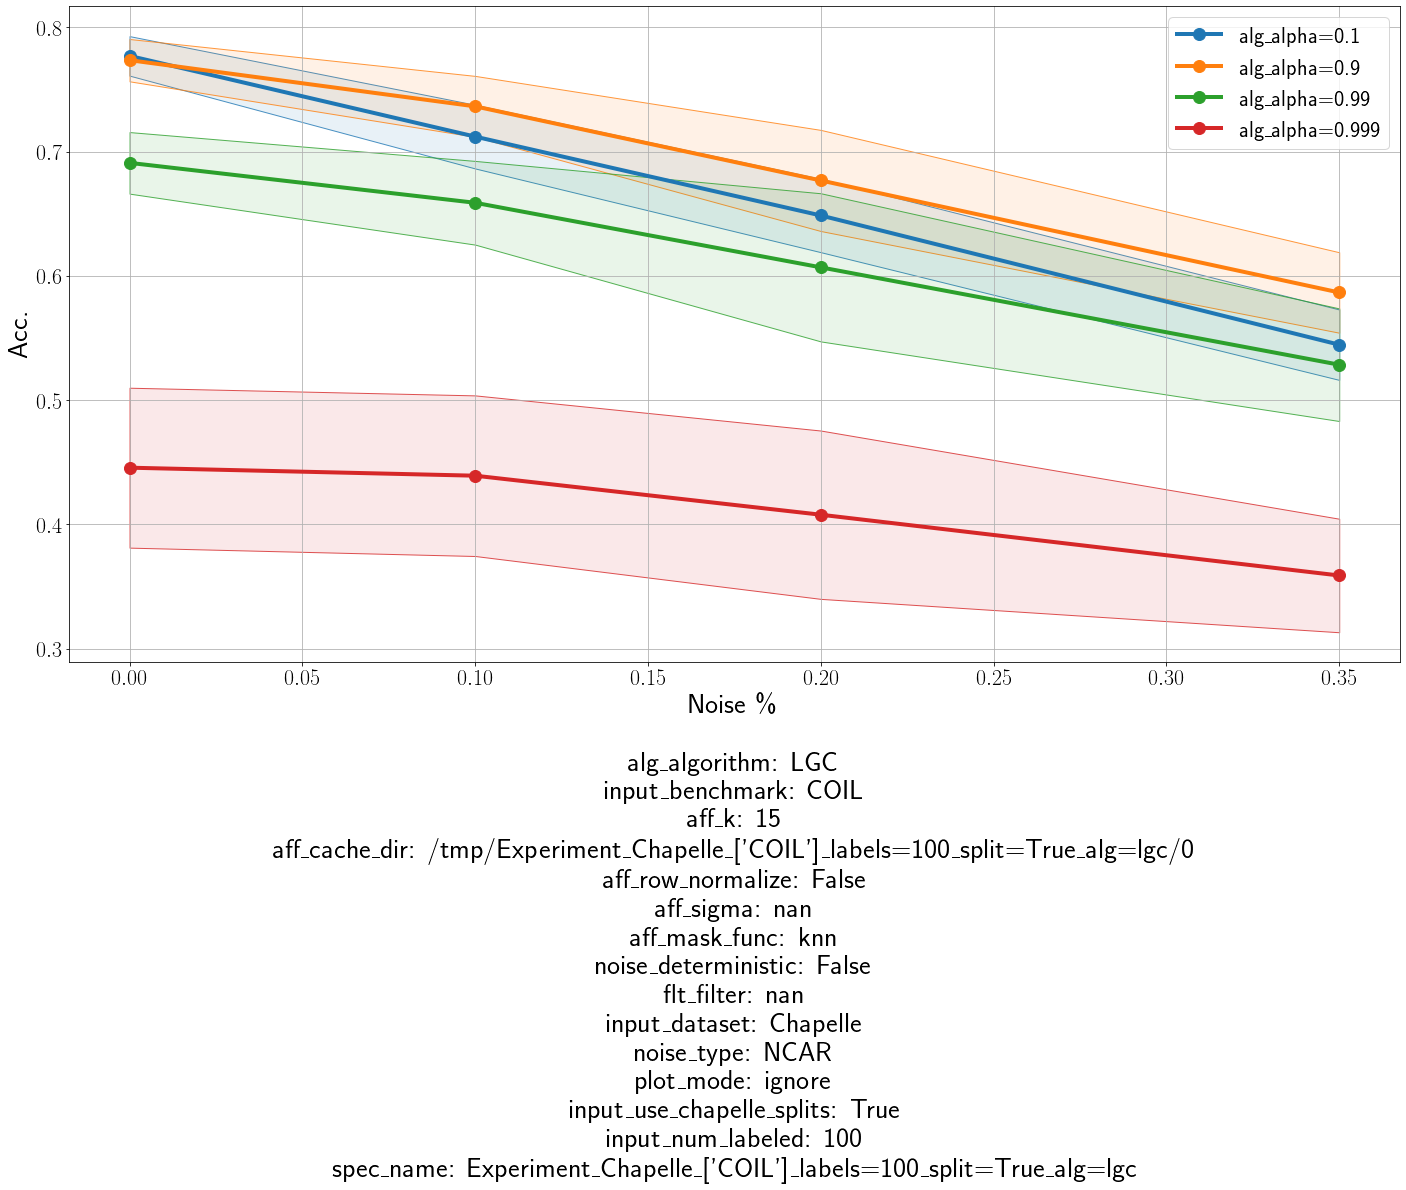

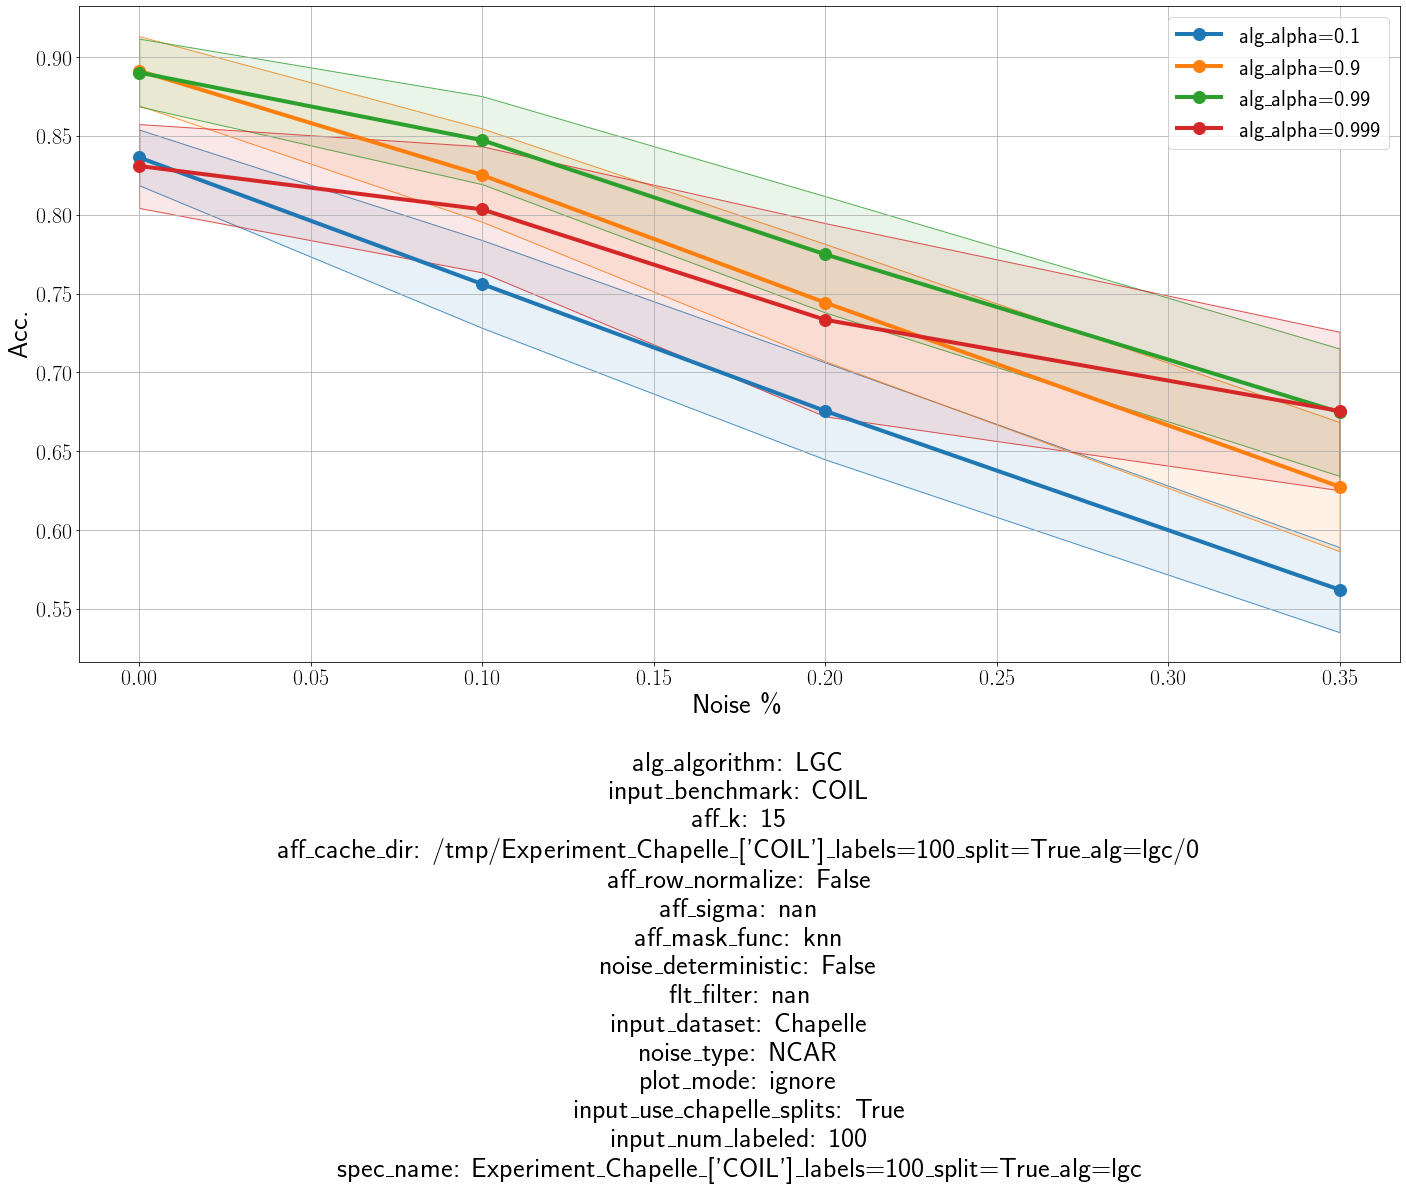

In [ ]:
#@title Visualization 1 --> Line plot
from tf_labelprop.output.visualize_statistics import create_visualization
create_visualization()


# **Tutorial 1, Part 2a**: Creating a LaTeX table with experiment data
---
Again, click the cell below this one to activate the user interface. 


This time you'll type **2** to select the table visualization

You'll select the relevant **output variable**, as well as a **vertical division (type v)** variable, where each unique value corresponds to a subdivision with vertical rules. Then, you'll need to categorize some more variables, much like for the line plot, but here the categories are slightly different:

Lastly, you'll need to categorize some of the variables as:
*   Type **g**: Use as group. Each combination of these variables yields a different table.
*   Type **h**: Use a horizontal subdivision. That is, in each plot there'll be one line for each combination of these variables
*   Type **c**: Each horizontal subdivision contains every combination of type c variables. Use this for ``alg_algorithm`` and individual parameters for the classifier. The maximum value of the output variable for varying type c variables and fixed type h and type v variables is marked as **bold**.
*   Type **i**: Variables to be ignored. Useful for stuff like ``affmat_cache_dir`` and other irrelevant variables.


In [ ]:
#@title Visualization 2 -> Creating LaTeX table
from tf_labelprop.output.visualize_statistics import create_visualization
create_visualization()

0 - Experiment_Chapelle_['COIL']_labels=100_split=True_alg=lgc
Enter comma-separated numbers corresponding to desired experiment
0
Selected files:
 /content/tf_labelprop/results/csvs/Experiment_Chapelle_['COIL']_labels=100_split=True_alg=lgc_joined.csv
Type subfolder name to place visualizations within f/content/tf_labelprop/results/visualizations:
exp_lgc
Will use save visualizations to /content/tf_labelprop/results/visualizations/exp_lgc.
Which visualization?  1-Line plot; 2-LaTeX Table (Use comma-separated values to use multiple)2
[2]
LaTeX Table Creation:

Dataframe columns:
aff_cache_dir
aff_dist_func
aff_k
aff_mask_func
aff_row_normalize
aff_sigma
alg_algorithm
alg_alpha
flt_filter
input_benchmark
input_dataset
input_num_labeled
input_use_chapelle_splits
noise_corruption_level
noise_deterministic
noise_type
out_CMN_acc_max
out_CMN_acc_mean
out_CMN_acc_median
out_CMN_acc_min
out_CMN_acc_sd
out_acc_labeled_max
out_acc_labeled_mean
out_acc_labeled_median
out_acc_labeled_min
out_acc_

# **Tutorial 1, Part 2b**: Transforming the LaTeX table to PDF, downloading them from Google Colab
---
 After the previous step is done, use the "Files" tab on the left and browse to ``content/tf_labelprop/results/visualizations/...`` and look for tables generated by the program within subfolders. Then, right-click the desired table and select "copy path". Paste this path onto the Form below, then hit the play button.

In [ ]:
#@title Visualization 2 --> Creating PDF from table
path_to_table = "/content/tf_labelprop/results/visualizations/exp_lgc/table.txt" #@param {type:"string"}
import os.path as osp
assert osp.isfile(path_to_table)
__folder = osp.dirname(path_to_table)
__file_name = osp.split(path_to_table)[-1]


beg = []

beg.append(r"\documentclass[a4paper]{article}")
beg.append(r"\usepackage{tabularx}")
beg.append(r"\usepackage{booktabs}")
beg.append(r"\usepackage[pass]{geometry}")
beg.append(r"\savegeometry{Mem}")
beg.append(r"\newgeometry{margin=4pt}")
beg.append(r"\usepackage{etoolbox}")
beg.append(r"\BeforeBeginEnvironment{tabular}{\begin{center}\fontsize{2}{3}\selectfont}")
beg.append(r"\AfterEndEnvironment{tabular}{\end{center}}")
beg.append(r"\begin{document}")

beg = [x+'\n' for x in beg]

file = open(osp.join(__folder,__file_name), "r")
beg.extend(file.readlines())

beg.append("\end{document}\n")
file.close()

new_latex = osp.join(__folder,"__table.txt")
new_pdf = osp.join(__folder,"__table.pdf")


file = open(new_latex, "w")
file.writelines(beg)
file.close()
print(__folder)
print(new_latex)
#new_latex = new_latex.encode('unicode_escape')
import subprocess
try:
  my_env = os.environ.copy()
  my_env["TABLEDIR"] = __folder
  my_env["TABLEFILE"] = new_latex
  
  my_command = "pdflatex -halt-on-error -output-directory $TABLEDIR $TABLEFILE"

  print(subprocess.check_output(["cat","$TABLEFILE"], env=my_env,shell=True))
  print(subprocess.check_output([my_command], env=my_env,shell=True))
except subprocess.CalledProcessError as e:
    for word in e.output.decode('utf-8').split('\n'):
      print(word)

from google.colab import files
if input("Download PDF file? (y/n)") == 'y':
  files.download(osp.join(__folder,"__table.pdf"))
if input("Download LaTeX file? (y/n)") == 'y':
  files.download(osp.join(__folder,"__table.txt"))





/content/tf_labelprop/results/visualizations/exp_lgc
/content/tf_labelprop/results/visualizations/exp_lgc/__table.txt
b''
b"This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)\n restricted \\write18 enabled.\nentering extended mode\n(/content/tf_labelprop/results/visualizations/exp_lgc/__table.txt\nLaTeX2e <2017-04-15>\nBabel <3.18> and hyphenation patterns for 3 language(s) loaded.\n(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls\nDocument Class: article 2014/09/29 v1.4h Standard LaTeX document class\n(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))\n(/usr/share/texlive/texmf-dist/tex/latex/tools/tabularx.sty\n(/usr/share/texlive/texmf-dist/tex/latex/tools/array.sty))\n(/usr/share/texlive/texmf-dist/tex/latex/booktabs/booktabs.sty)\n(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty\n(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)\n(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)\

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download LaTeX file? (y/n)n


+\\_table.txt


In [ ]:
!nvidia-smi